# Introduction
In this notebook, we analyse the relationships between individual Option Greeks with individual factors that influence **European (Calls) options** prices according to the Black-Scholes option pricing model.

# Black-Scholes
The Black-Scholes model is a mathematical equation that estimates the theoretical value of derivatives (mainly options), taking into account the impact of time and other risk factors:

$$C=S\times N(d_1)-K\times e^{-rT}\times N(d_2)$$

where:
- $d_1=\frac{ln^S_K+(r+\frac{\sigma^2_v}{2})t}{\sigma_s\sqrt{T}}$
- $d_2=d_1-\sigma_s\sqrt{T}$

and:
- $C$ = Call option price
- $S$ = Spot price
- $K$ = Strike price
- $r$ = Risk-free interest rate (%)
- $T$ = Time to maturity (years)
- $\sigma$ = Volatility (%)
- $N$ = A normal distribution, typically with mean 0 and standard deviation 1

Note:
1. Our Black-Scholes implementation will have a time input in days instead of years.
2. Black-Scholes doesn't account for dividends.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
N = norm.cdf

def d1(S, K, r, T, sigma):
    return (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

def d2(S, K, r, T, sigma):
    return d1(S, K, r, T, sigma) - sigma * np.sqrt(T)

def BS_CALL(S, K, T, r, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return S * N(d1_value) - K * np.exp(-r*T)* N(d2_value)

def BS_PUT(S, K, T, r, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return K*np.exp(-r*T)*N(-d2_value) - S*N(-d1_value)

# Constant Variables for Analysis
Throughout this analysis of Option greeks, we will assume the following default values for each factor that drives options prices:

In [3]:
S = 100         # Spot price (Change this to analyse ATM, OTM and ITM options)
K = 100         # Strike price
t = 30          # Time to maturity in DAYS
r = 0.05        # Risk-free interest rate
sigma = 0.5     # Volatility of the underlying

# Delta
Delta measures the amount of change in option price for a $1 increase in the underlying.

E.g. ABC stock is trading at $100 per share. A CALL ABC option is trading at $10 per share. If Delta = 0.5, then:
- If ABC increases to $101, CALL ABC increases to $10.5.
- If ABC decreases to $99, CALL ABC decreases to $9.5.

## Deriving Delta
Since delta measures the rate of change of the option's price w.r.t. the underlying's price, we can express delta as:
$$\Delta=\frac{\partial C}{\partial S}=N(d_1)=\frac{1}{\sqrt{2\pi}}\int^{d_1}_{-\infty}e^{\frac{-t^2}{2}}dt$$
which is simply the cumulative density function (CDF) of the standard normal distribution. Therefore we have:
$$\Delta_{call}=N(d_1)$$
$$\Delta_{put}=N(d_1)-1$$

In [4]:
def delta_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.cdf(d1_value)

def delta_put(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.cdf(d1_value) - 1

## Delta vs. Spot Price

In [5]:
def delta_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_deltas = delta_call(S, K, r, T, sigma)
    puts_deltas = delta_put(S, K, r, T, sigma)

    plt.title('Delta vs. Spot Price')
    plt.plot(S, calls_deltas, label='CALL Delta')
    plt.plot(S, puts_deltas, label='PUT Delta')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Delta')
    plt.legend()

    # Add vertical dotted lines
    plt.axvline(x=80, color='gray', linestyle='--')
    plt.axvline(x=100, color='gray', linestyle='--')
    plt.axvline(x=120, color='gray', linestyle='--')

    # Add labels for the dotted lines
    plt.text(80, 0.5, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, 0.5, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, 0.5, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(80, -0.5, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, -0.5, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, -0.5, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')

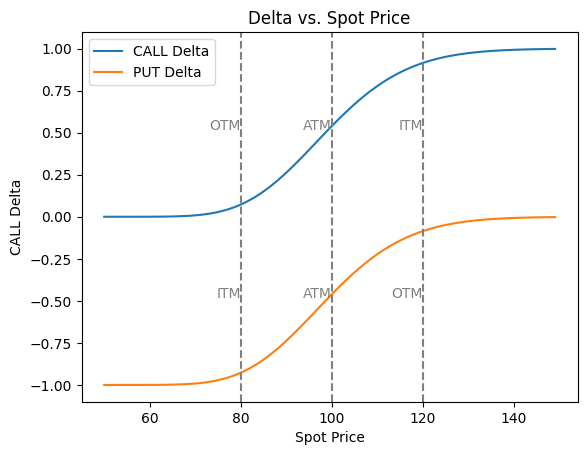

In [6]:
delta_spot_analysis(K, r, t, sigma)

## Delta vs. Time


In [7]:
def delta_time_analysis(S, K, r, sigma, moneyness, option_type):
    times = np.arange(100, 0, -1)
    if option_type.upper() == "CALL":
        deltas = [delta_call(S, K, r, t/365, sigma) for t in times]
    elif option_type.upper() == "PUT":
        deltas = [delta_put(S, K, r, t/365, sigma) for t in times]

    plt.plot(times, deltas, label=f'{moneyness} {option_type.upper()} Delta')

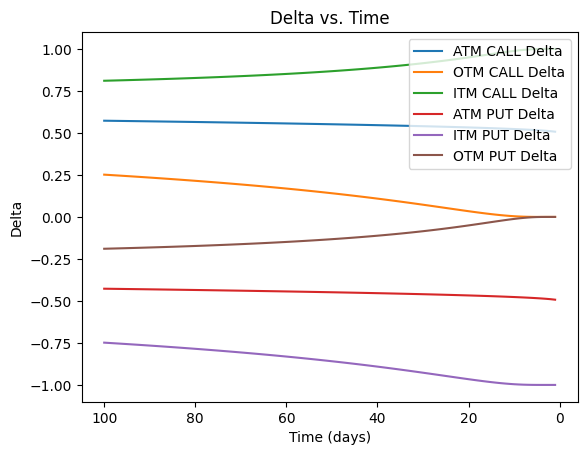

In [8]:
# Plot all six curves on the same plot
plt.figure()
delta_time_analysis(S, K, r, sigma, moneyness="ATM", option_type="CALL")
delta_time_analysis(S-20, K, r, sigma, moneyness="OTM", option_type="CALL")
delta_time_analysis(S+20, K, r, sigma, moneyness="ITM", option_type="CALL")
delta_time_analysis(S, K, r, sigma, moneyness="ATM", option_type="PUT")
delta_time_analysis(S-20, K, r, sigma, moneyness="ITM", option_type="PUT")
delta_time_analysis(S+20, K, r, sigma, moneyness="OTM", option_type="PUT")

plt.title('Delta vs. Time')
plt.xlabel('Time (days)')
plt.ylabel('Delta')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

## Delta vs Volatility

In [9]:
def delta_volatility_analysis(S, K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_deltas = delta_call(S, K, r, t/365, vol)
    puts_deltas = delta_put(S, K, r, t/365, vol)
    plt.plot(S, calls_deltas, label=f'Delta (Volatility {int(vol * 100)}%)')
    plt.plot(S, puts_deltas, label=f'Delta (Volatility {int(vol * 100)}%)')

    plt.title('CALL & PUT Delta vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('Delta')
    plt.legend()

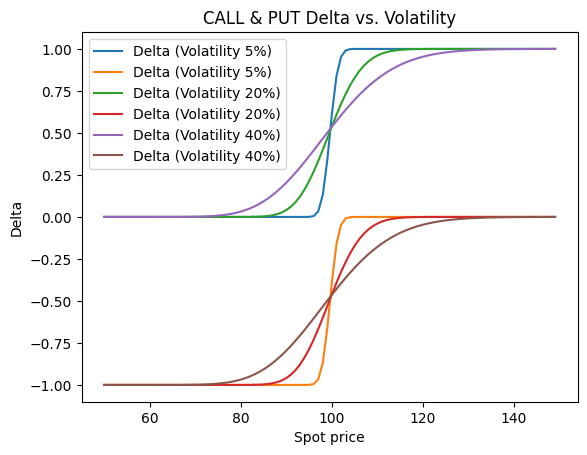

In [10]:
delta_volatility_analysis(S, K, r, t, vol=0.05)
delta_volatility_analysis(S, K, r, t, vol=0.2)
delta_volatility_analysis(S, K, r, t, vol=0.4)

# Gamma
Gamma measures the amount of change in Delta for a $1 increase in the underlying.

E.g. ABC stock is trading at $100 per share. A CALL ABC option is trading at $10 per share. If Delta = 0.5 and Gamma = 0.15, then:
- If ABC increases to $101, CALL ABC increases to $10.5 and delta increases to 0.65.
- If ABC decreases to $99, CALL ABC decreases to $9.5 and delta decreases to 0.35.

## Deriving Gamma
Gamma measures the rate of change of delta. From above, we already know the formula for calculating Delta. To find gamma, we simply differentiate Delta w.r.t. the underlying price S again:
$$\Gamma=\frac{\partial\Delta}{\partial S}=\frac{\partial^2C}{\partial S^2}=\frac{N^{'}(d_1)}{S\sigma\sqrt{t}}=\frac{1}{S\sigma\sqrt{t}}\times\frac{1}{\sqrt{2\pi}}e^{\frac{-d_1^2}{2}}$$
where $N^{'}(d_1)$ is simply the probability density function (pdf) of the standard normal distribution

In [11]:
def gamma_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return norm.pdf(d1_value) / (S * sigma * np.sqrt(T))

## Gamma vs. Spot Price

In [12]:
def gamma_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_gammas = gamma_call(S, K, r, T, sigma)

    plt.title('CALL & PUT Gamma vs. Spot Price')
    plt.plot(S, calls_gammas, label='Gamma')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL & PUT Gamma')
    plt.legend()

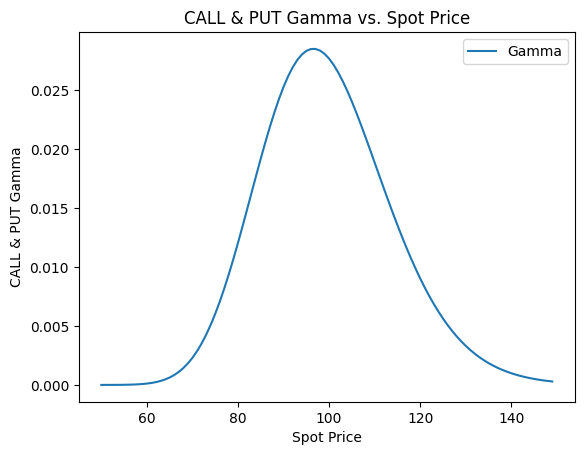

In [13]:
gamma_spot_analysis(K, r, t, sigma)

## Gamma vs. Time

In [14]:
def gamma_time_analysis(S, K, r, sigma, moneyness):
    times = np.arange(100, 0, -1)
    calls_gammas = [gamma_call(S, K, r, t/365, sigma) for t in times]

    plt.title('CALL & PUT Gamma vs. Time')
    plt.plot(times, calls_gammas, label=f'{moneyness} Gamma')
    plt.xlabel('Time (days)')
    plt.gca().invert_xaxis()
    plt.ylabel('CALL & PUT Gamma')
    plt.legend()

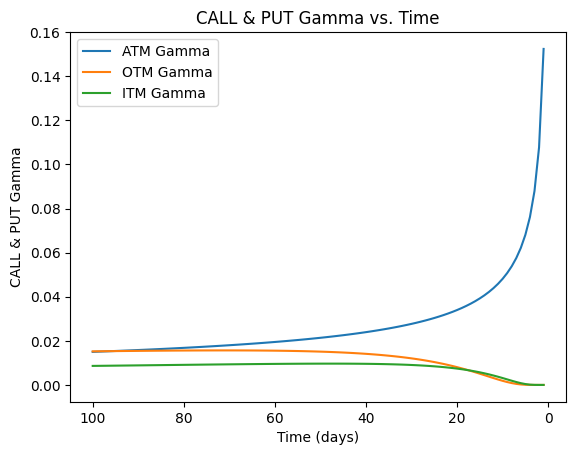

In [15]:
gamma_time_analysis(S, K, r, sigma, moneyness='ATM')
gamma_time_analysis(S-20, K, r, sigma, moneyness='OTM')
gamma_time_analysis(S+20, K, r, sigma, moneyness='ITM')

## Gamma vs. Volatility

In [16]:
def gamma_volatility_analysis(S, K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_gammas = gamma_call(S, K, r, t/365, vol)
    plt.plot(S, calls_gammas, label=f'Gamma (Volatility {int(vol * 100)}%)')

    plt.title('CALL & PUT Gamma vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('CALL & PUT Gamma')
    plt.legend()

    # Add vertical dotted lines
    plt.axvline(x=80, color='gray', linestyle='--')
    plt.axvline(x=100, color='gray', linestyle='--')
    plt.axvline(x=120, color='gray', linestyle='--')

    # Add labels for the dotted lines
    plt.text(80, 0.1, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, 0.1, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, 0.1, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')

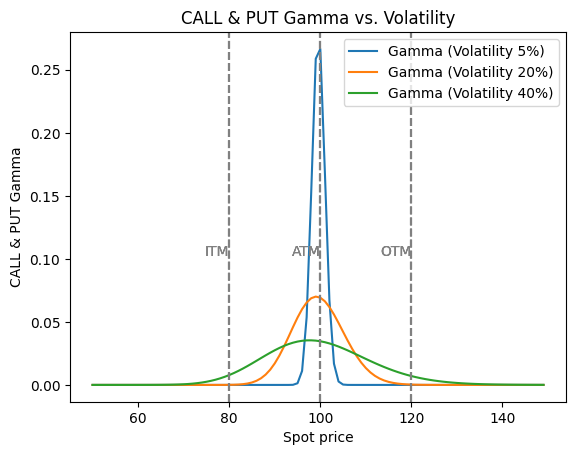

In [17]:
gamma_volatility_analysis(S, K, r, t, vol=0.05)
gamma_volatility_analysis(S, K, r, t, vol=0.2)
gamma_volatility_analysis(S, K, r, t, vol=0.4)

# Vega
Vega measures the amount of change in option prices for a 1% increase in volatility:

$$v_{call/put}=\frac{1}{100}S\times N^{'}(d_1)\times\sqrt{T}$$

In [18]:
def vega(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    return S * norm.pdf(d1_value) * np.sqrt(T) / 100

## Vega vs. Spot Price

In [19]:
def vega_spot_analysis(K, r, t, sigma):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_vegas = vega(S, K, r, T, sigma)

    plt.title('Vega vs. Spot Price')
    plt.plot(S, calls_vegas, label=f'CALL {K} Vega')
    plt.xlabel('Spot Price')
    plt.ylabel('Vega')
    plt.legend()

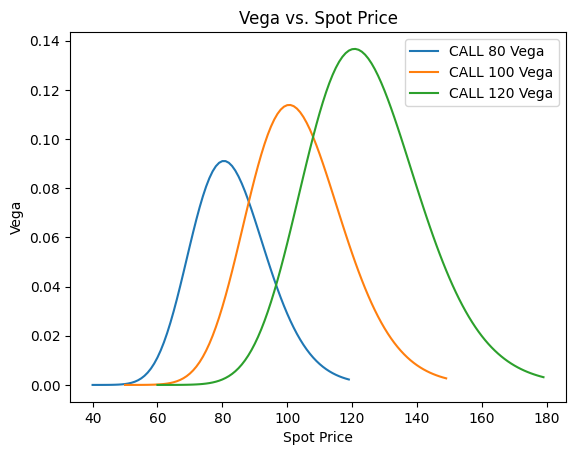

In [20]:
vega_spot_analysis(K-20, r, t, sigma)
vega_spot_analysis(K, r, t, sigma)
vega_spot_analysis(K+20, r, t, sigma)

## Vega vs. Time

In [21]:
def vega_time_analysis(S, K, r, sigma, t):
    T = t / 365
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_vegas = vega(S, K, r, T, sigma)

    plt.title('Vega vs. Different days till expiration')
    plt.plot(S, calls_vegas, label=f'{t} days till expiration')
    plt.xlabel('Spot Price')
    plt.ylabel('Vega')
    plt.legend()

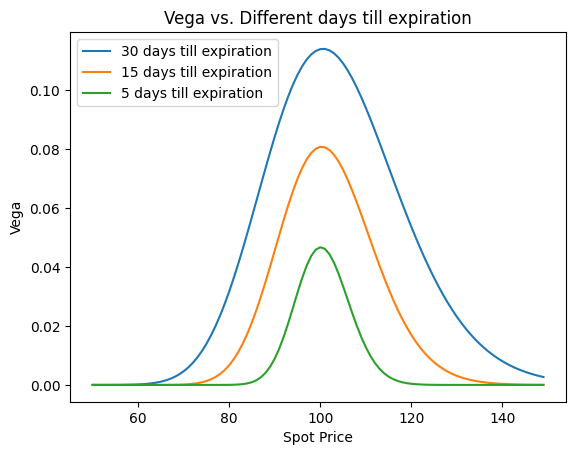

In [22]:
vega_time_analysis(S, K, r, sigma, t)
vega_time_analysis(S, K, r, sigma, t-15)
vega_time_analysis(S, K, r, sigma, t-25)

## Vega vs. Volatility

In [23]:
def vega_volatility_analysis(S, K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_vegas = vega(S, K, r, t/365, vol)
    plt.plot(S, calls_vegas, label=f'Vega (Volatility {int(vol * 100)}%)')

    plt.title('Vega vs. Volatility')
    
    plt.xlabel('Spot price')
    plt.ylabel('Vega')
    plt.legend()

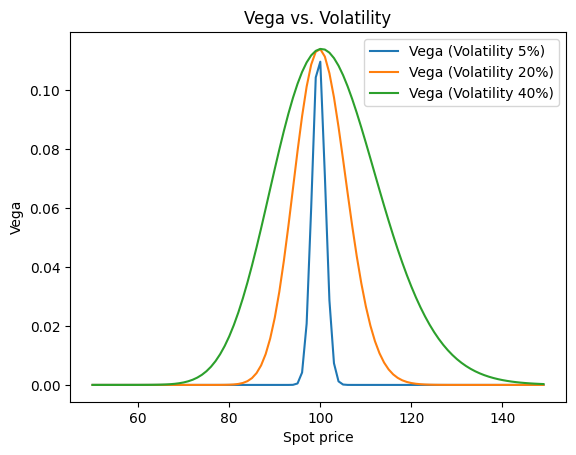

In [24]:
vega_volatility_analysis(S, K, r, t, vol=0.05)
vega_volatility_analysis(S, K, r, t, vol=0.2)
vega_volatility_analysis(S, K, r, t, vol=0.4)

# Theta
Theta measures the amount of change in option prices as time passes. Theta is always negative for both Calls and Puts.
$$\theta_{call}=-\frac{S\times N^{'}(d_1)\times\sigma}{2\sqrt{T}}-r\times K\times e^{-rT}\times N(d_2)$$

$$\theta_{put}=-\frac{S\times N^{'}(d_1)\times\sigma}{2\sqrt{T}}-r\times K\times e^{-rT}\times N(-d_2)$$

In [25]:
def theta_call(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return (-S * norm.pdf(d1_value) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2_value))

def theta_put(S, K, r, T, sigma):
    d1_value = d1(S, K, r, T, sigma)
    d2_value = d2(S, K, r, T, sigma)
    return (-S * norm.pdf(d1_value) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2_value))

## Theta vs. Spot Price

In [63]:
def theta_spot_analysis(K, r, t, sigma, moneyness):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_thetas = theta_call(S, K, r, t / 365, sigma)

    plt.title('CALL Theta vs. Spot Price')
    plt.plot(S, calls_thetas, label=f'{moneyness} Call Theta')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Theta')
    plt.legend()

    # Add vertical dotted lines
    plt.axvline(x=80, color='gray', linestyle='--')
    plt.axvline(x=100, color='gray', linestyle='--')
    plt.axvline(x=120, color='gray', linestyle='--')

    # Add labels for the dotted lines
    plt.text(80, -20, 'OTM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(100, -20, 'ATM', color='gray', verticalalignment='bottom', horizontalalignment='right')
    plt.text(120, -20, 'ITM', color='gray', verticalalignment='bottom', horizontalalignment='right')

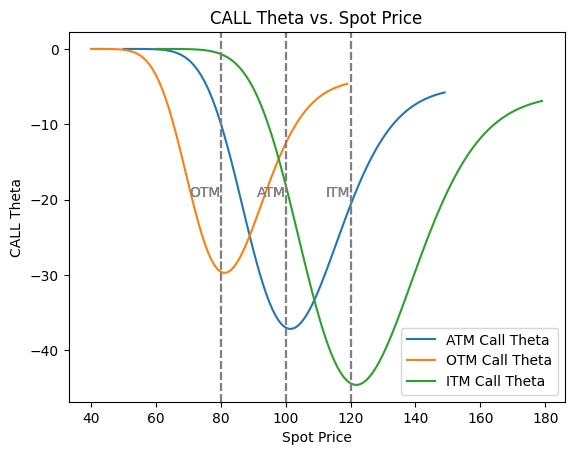

In [64]:
theta_spot_analysis(K, r, t, sigma, moneyness='ATM')
theta_spot_analysis(K-20, r, t, sigma, moneyness='OTM')
theta_spot_analysis(K+20, r, t, sigma, moneyness='ITM')

## Theta vs. Time

In [87]:
def theta_time_analysis(S, K, r, sigma, moneyness):
    times = np.arange(100, 0, -1)
    calls_thetas = [theta_call(S, K, r, t/365, sigma) for t in times]

    plt.title('CALL Theta vs. Time')
    plt.plot(times, calls_thetas, label=f'{moneyness} Calls Theta')
    plt.xlabel('Time (days)')
    plt.gca().invert_xaxis()
    plt.ylabel('CALL Theta')
    plt.legend()

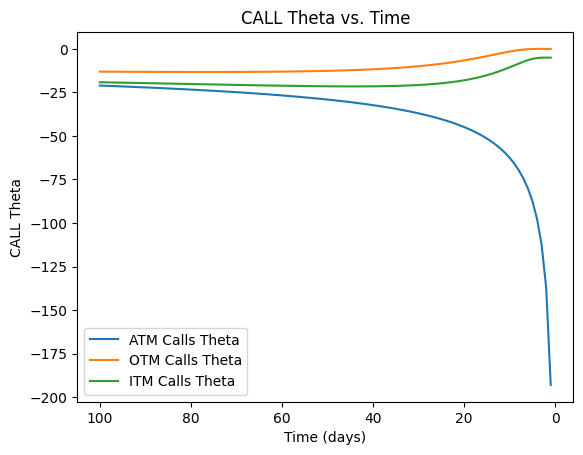

In [88]:
theta_time_analysis(S, K, r, sigma, moneyness='ATM')
theta_time_analysis(S-20, K, r, sigma, moneyness='OTM')
theta_time_analysis(S+20, K, r, sigma, moneyness='ITM')

## Theta vs. Volatility

In [89]:
def theta_volatility_analysis(K, r, t, vol):
    S = np.arange(K * 0.5, K * 1.5, 1)
    calls_thetas = theta_call(S, K, r, t / 365, vol)

    plt.title('CALL Theta vs. Volatility')
    plt.plot(S, calls_thetas, label=f'Theta (Volatility {int(vol * 100)}%)')
    plt.xlabel('Spot Price')
    plt.ylabel('CALL Theta')
    plt.legend()

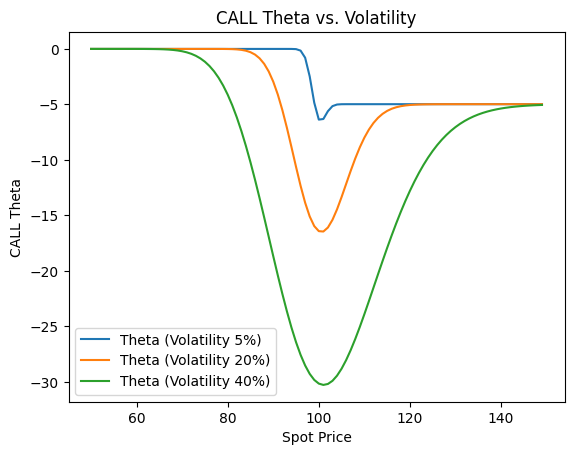

In [90]:
theta_volatility_analysis(K, r, t, vol=0.05)
theta_volatility_analysis(K, r, t, vol=0.2)
theta_volatility_analysis(K, r, t, vol=0.4)